In [58]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as ss
import seaborn as sns
from cmocean import cm as cmo
%matplotlib inline

sns.set_style("whitegrid")

In [3]:
# June, July & August data from 1979-2020
ds = xr.open_dataset("ERA5_1979-2020.nc", chunks={'time':100}).sel(expver=1)
ds
# what is expver? 1 and 5

# t2m: 2 metre temp
# slhf: surface latent heat flux
# sshf: surface sensible heat flux
# swvl1: volumetric soil water layer 1 ie top 7 cm in soil

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-12 20:26:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [33]:
xr.open_dataset("ERA5_1979-2020.nc", chunks={'time':100}).sel(expver=5) # era5t data

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-12 20:26:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
# preprocessing data

# slhf and sshf: multiply by -1/86400 to correct direction of energy flow and
# convert from J/m^2 to W/m^2 (era5 stores data on daily basis)
ds['slhf'] = ds.slhf*(-1/86400)
ds.slhf.attrs['units'] = "W m**-2"
ds.slhf.attrs['long_name'] = "Surface latent heat flux"

ds['sshf'] = ds.sshf*(-1/86400)
ds.sshf.attrs['units'] = "W m**-2"
ds.sshf.attrs['long_name'] = "Surface sensible heat flux"

# swvl1: multiply by 70 to convert from m^3/m^3 to kg in top 7 cm
ds['swvl1'] = ds.swvl1*(70)
ds.swvl1.attrs['units'] = "kg m**-2 in top 7 cm"
ds.swvl1.attrs['long_name'] = "Volumetric soil water layer 1"

In [123]:
# def plot_climatology(x):
#     avg = x.mean('time')
#     lats = ds.latitude
#     longs = ds.longitude

#     plt.figure(figsize=(12,8))
#     ax = plt.axes(projection=ccrs.PlateCarree())

#     plt.contourf(longs, lats, avg)
#     plt.colorbar(shrink=0.7)
#     ax.coastlines()

#     plt.title("Climatology of {}, Units: {}".format(x.attrs['long_name'], x.attrs['units']))
#     plt.show()

def plot_climatology(x, show_ocean=True, lmin=None, lmax=None, cmap=cmo.thermal):
    avg = x.mean('time')
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    avg.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmap)
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
        
    plt.title("Climatology of {}, Units: {}".format(x.attrs['long_name'], x.attrs['units']))

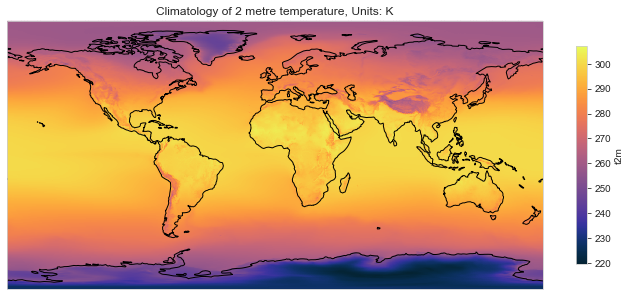

In [5]:
plot_climatology(ds.t2m)

In [13]:
def jja(month):
    return (month >= 6) & (month <= 8)

def djf(month):
    return (month == 12) | (month <= 2)

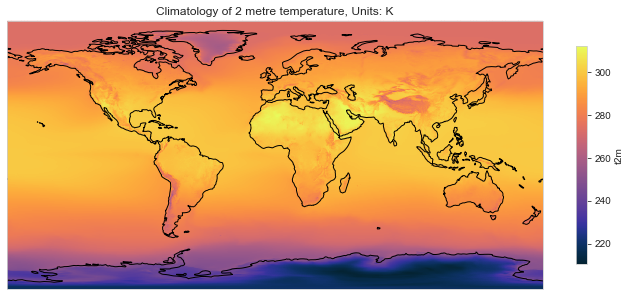

In [6]:
plot_climatology(ds.t2m.sel(time=jja(ds.t2m['time.month'])))

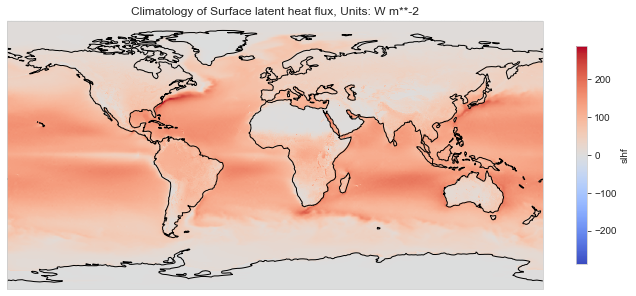

In [7]:
plot_climatology(ds.slhf, cmap='coolwarm')

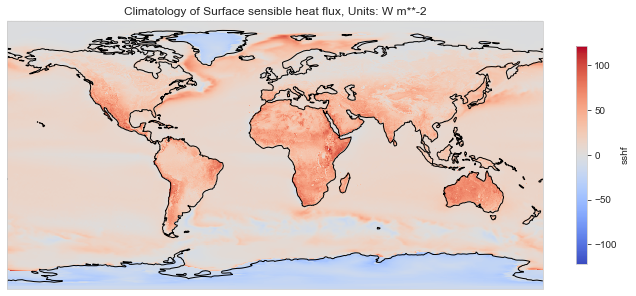

In [8]:
plot_climatology(ds.sshf, cmap='coolwarm')

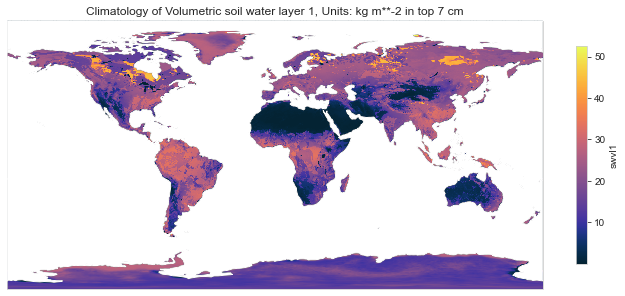

In [9]:
plot_climatology(ds.swvl1, show_ocean=False)

In [11]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_seasonality(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.month').map(remove_time_mean)

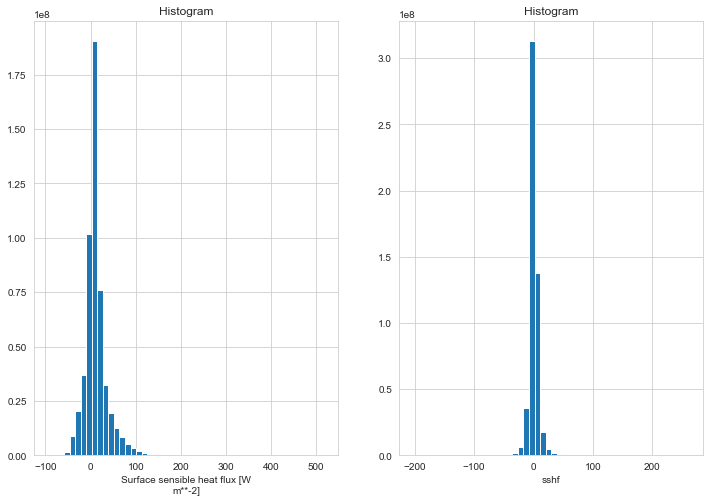

In [12]:
def wos(x):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    x.plot(bins=50)
    plt.subplot(1, 2, 2)
    (remove_seasonality(x)).plot(bins=50)
    plt.show()

wos(ds.sshf)

In [64]:
def plot_variance(x, show_ocean=True, lmin=None, lmax=None):
    x_without_seasonality = remove_seasonality(x)
    var = x_without_seasonality.var('time')

    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    var.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmo.thermal)
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
        
    plt.title("Variance of {}, Units: ({})^2".format(x.attrs['long_name'], x.attrs['units']))

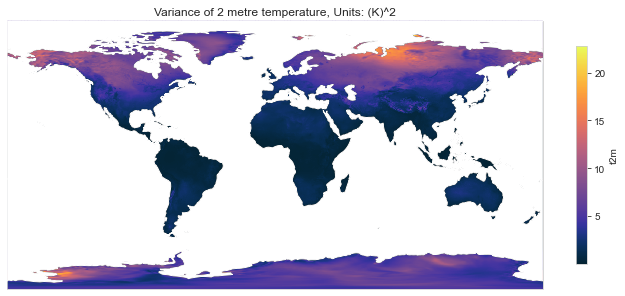

In [15]:
plot_variance(ds.t2m, False)

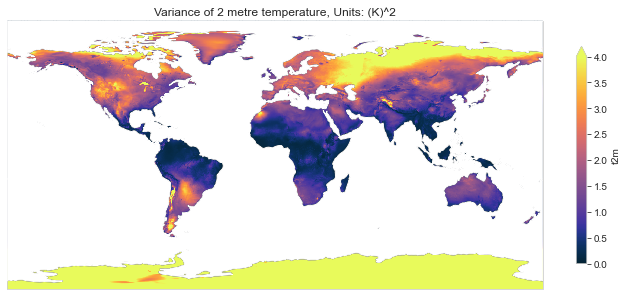

In [16]:
plot_variance(ds.t2m.sel(time=jja(ds.t2m['time.month'])), False, 0, 4)

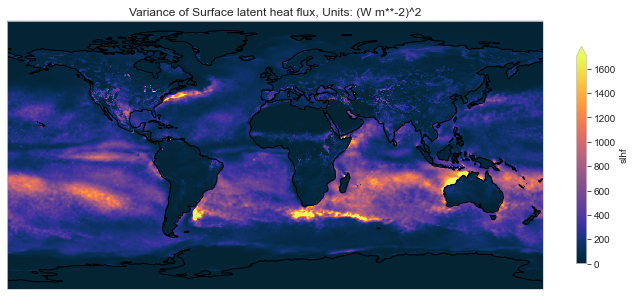

In [67]:
def june(month):
    return(month==6)

plot_variance(ds.slhf.sel(time=june(ds.slhf['time.month'])), True, 0, 1700)

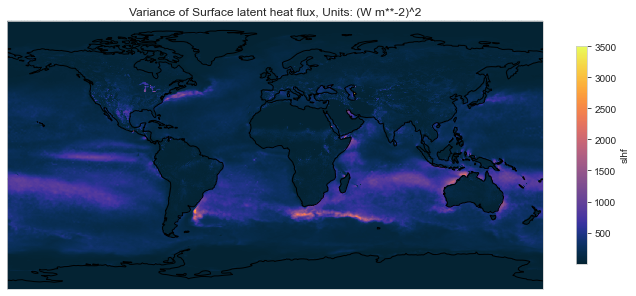

In [65]:
plot_variance(ds.slhf)

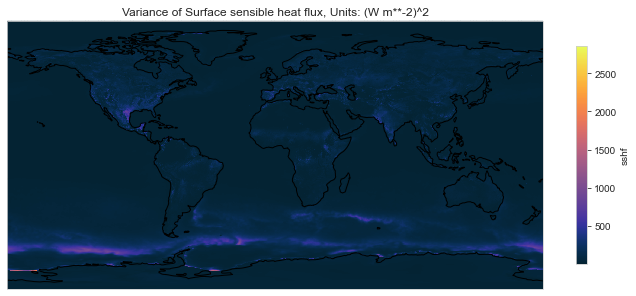

In [66]:
plot_variance(ds.sshf)

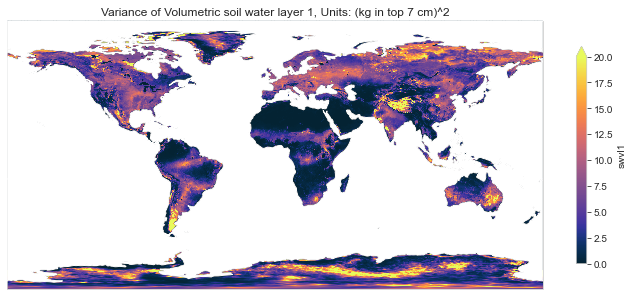

In [70]:
plot_variance(ds.swvl1, False, 0, 20)

In [71]:
# contourf has no way to limit colorbars
# try to use imshow instead of pcolormesh since its faster

def plot_skewness(x, show_ocean=True):
    x_without_seasonality = remove_seasonality(x)
    skew = ss.skew(x_without_seasonality, axis=x_without_seasonality.get_axis_num('time'))
    lats = ds.latitude
    longs = ds.longitude

    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.contourf(longs, lats, skew, cmap='coolwarm')
    plt.colorbar(shrink=0.7)
    ax.coastlines()
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

    plt.title("Skewness of {}".format(x.attrs['long_name']))
    plt.show()

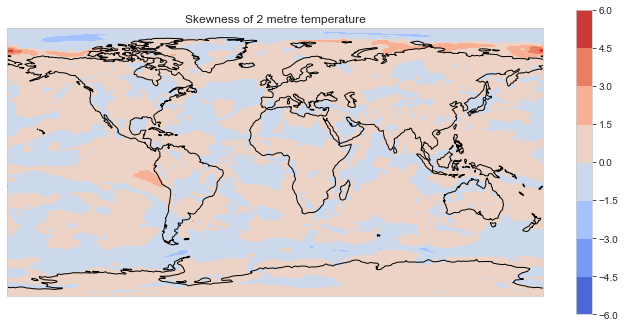

In [72]:
plot_skewness(ds.t2m)

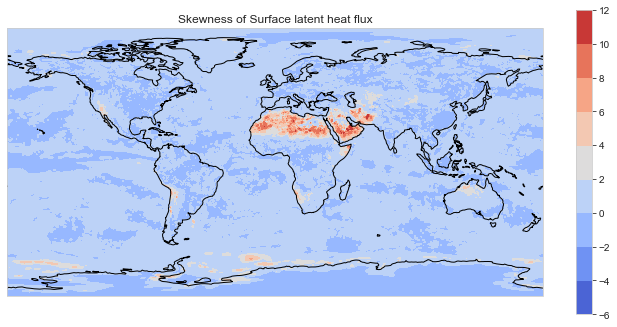

In [73]:
plot_skewness(ds.slhf)

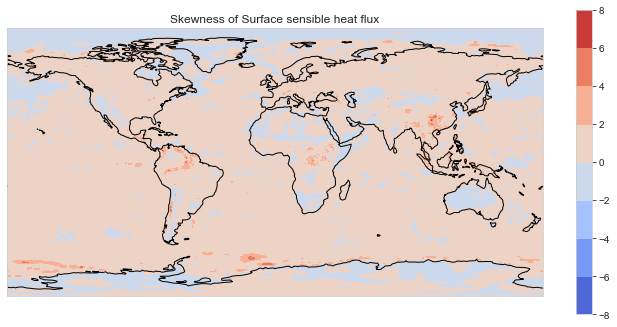

In [74]:
plot_skewness(ds.sshf)

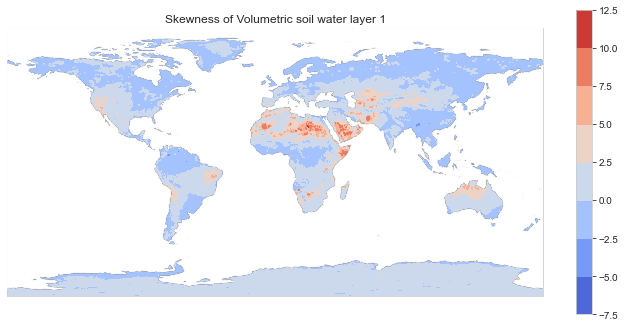

In [75]:
plot_skewness(ds.swvl1, False)

In [76]:
def plot_kurtosis(x, show_ocean=True):
    x_without_seasonality = remove_seasonality(x)
    kurt = ss.kurtosis(x_without_seasonality, axis=x_without_seasonality.get_axis_num('time'))
    lats = ds.latitude
    longs = ds.longitude

    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.contourf(longs, lats, kurt, cmap='coolwarm')
    plt.colorbar(shrink=0.7)
    ax.coastlines()
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

    plt.title("Kurtosis of {}".format(x.attrs['long_name']))
    plt.show()

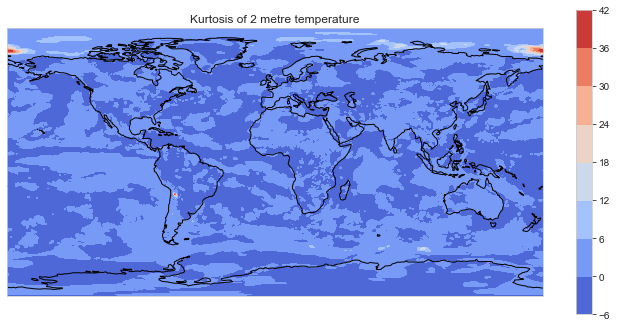

In [77]:
plot_kurtosis(ds.t2m)

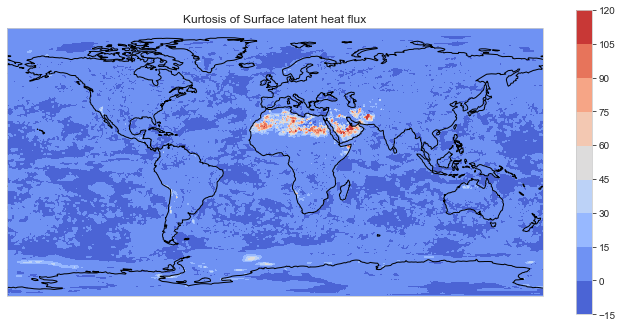

In [78]:
plot_kurtosis(ds.slhf)

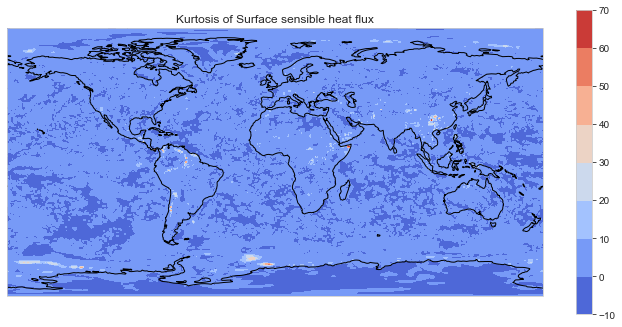

In [79]:
plot_kurtosis(ds.sshf)

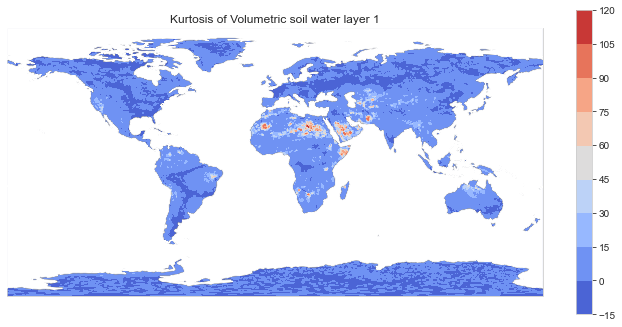

In [80]:
plot_kurtosis(ds.swvl1, False)

In [81]:
def plot_corr(x, y):
    c = xr.corr(remove_seasonality(x), remove_seasonality(y), dim='time')
    lats = ds.latitude
    longs = ds.longitude

    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.contourf(longs, lats, c, cmap='coolwarm')
    plt.colorbar(shrink=0.7)
    ax.coastlines()
    
    # look into correlations over ocean
    ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

    plt.title("Correlation between {} and {}".format(x.attrs['long_name'], y.attrs['long_name']))
    plt.show()

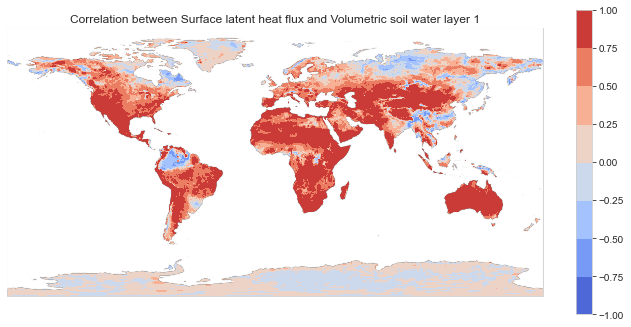

In [82]:
plot_corr(ds.slhf, ds.swvl1)

In [14]:
jja_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=jja(ds.t2m['time.month']))), 
        remove_seasonality(ds.swvl1.sel(time=jja(ds.t2m['time.month']))), dim='time')

djf_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=djf(ds.t2m['time.month']))), 
        remove_seasonality(ds.swvl1.sel(time=djf(ds.t2m['time.month']))), dim='time')

In [14]:
def southern_hemisphere(latitude):
    return (latitude<0)

c

<xarray.DataArray (latitude: 721, longitude: 1440)>
dask.array<truediv, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1

In [15]:
c = xr.concat([jja_corr.where(jja_corr['latitude']>=0, drop=True), 
               djf_corr.where(djf_corr['latitude']<0, drop=True)],
              dim='latitude')

In [43]:
jja_corr.where(jja_corr['latitude']>=0, drop=True)

<xarray.DataArray (latitude: 361, longitude: 1440)>
dask.array<where, shape=(361, 1440), dtype=float64, chunksize=(361, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
    expver     int32 1

In [46]:
c

<xarray.DataArray (latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(721, 1440), dtype=float64, chunksize=(361, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1

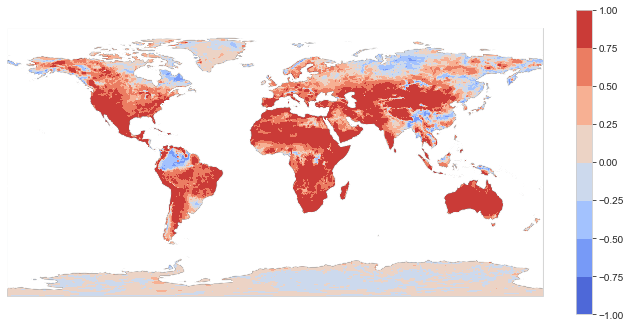

In [109]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, jja_corr, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

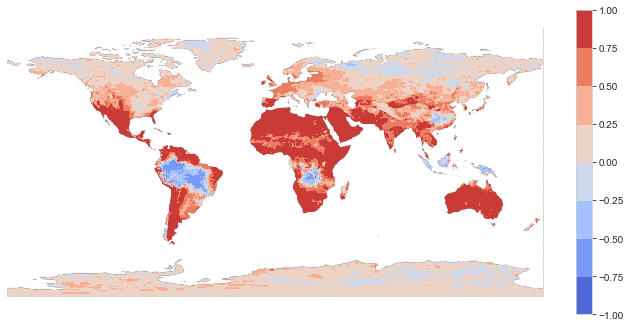

In [32]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, djf_corr, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

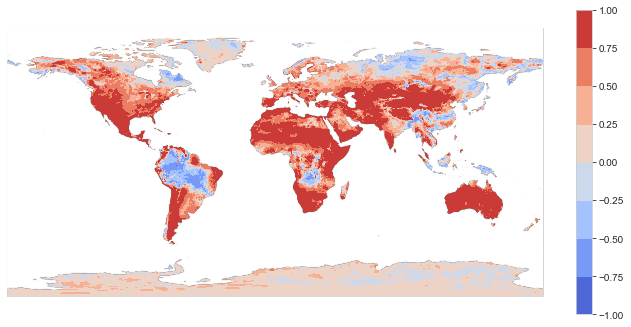

In [48]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

In [61]:
swvl1 = ds.swvl1.where(lambda x: x>0.001)
ds.swvl1.sel(latitude=-57, longitude=15, method='nearest').values

array([ 0.000678  , -0.00014395,  0.000678  , -0.00014395, -0.00014395,
       -0.00096589,  0.000678  , -0.00014395, -0.00014395,  0.000678  ,
       -0.00014395, -0.00014395, -0.00096589, -0.00096589, -0.00014395,
        0.000678  , -0.00014395, -0.00014395, -0.00014395,  0.000678  ,
        0.000678  , -0.00014395,  0.000678  ,  0.000678  ,  0.000678  ,
       -0.00096589, -0.00014395, -0.00014395,  0.000678  , -0.00014395,
       -0.00014395, -0.00014395, -0.00014395,  0.000678  , -0.00096589,
        0.000678  , -0.00014395, -0.00014395, -0.00096589, -0.00014395,
       -0.00014395,  0.000678  , -0.00014395, -0.00014395,  0.000678  ,
       -0.00014395, -0.00014395, -0.00014395, -0.00014395, -0.00014395,
       -0.00014395,  0.000678  , -0.00014395, -0.00014395, -0.00014395,
       -0.00014395, -0.00014395, -0.00014395, -0.00014395, -0.00014395,
       -0.00096589, -0.00014395, -0.00096589,  0.000678  , -0.00014395,
       -0.00096589, -0.00096589, -0.00014395, -0.00014395, -0.00

In [48]:
weights = np.cos(np.deg2rad(swvl1.latitude))
weighted_swvl1 = swvl1.weighted(weights)
swvl1_global_mean = weighted_swvl1.mean(skipna=True)

In [51]:
swvl1_global_mean.values

array(17.435402, dtype=float32)

In [55]:
mean_swvl1 = ds.swvl1.mean(dim='time')
global_eq_clim = mean_swvl1.where(lambda x: (x < (17.435402+1)) & (x > (17.435402-1)))
# look into level

In [56]:
global_eq_clim

<xarray.DataArray 'swvl1' (latitude: 721, longitude: 1440)>
dask.array<where, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1

Text(0.5, 1.0, 'Correlations between swvl1 and slhf. Contour line superimposed where climatological swvl1 = global mean swvl1')

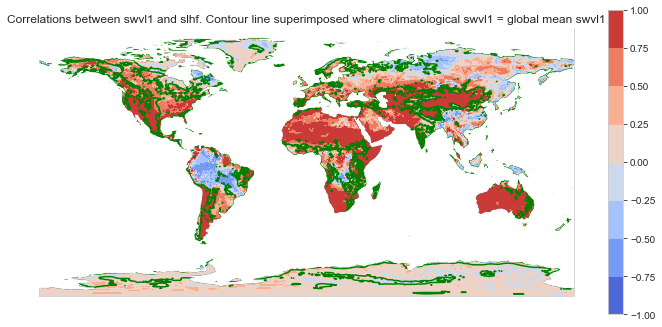

In [70]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

plt.contour(longs, lats, mean_swvl1, levels=[17.435402], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
plt.title("Correlations between swvl1 and slhf. Contour line superimposed where climatological swvl1 = global mean swvl1")